<a href="https://colab.research.google.com/github/HSAkash/Guava-Disease/blob/main/guava_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import Data

## Set images paths

In [ ]:

train_dir = "Guava Disease Dataset/train"
test_dir = "Guava Disease Dataset/test"
valid_dir = "Guava Disease Dataset/val"

## Kaggle
# train_dir = "../input/guava-disease-dataset-4-types/Guava Disease Dataset/train"
# test_dir = "../input/guava-disease-dataset-4-types/Guava Disease Dataset/test"
# valid_dir = "../input/guava-disease-dataset-4-types/Guava Disease Dataset/val"

## Data Rescaling and augmentation

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

## Load images and Shuffle and prefetch

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

valid_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = valid_datasets.class_names
valid_data = valid_datasets.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1377 files belonging to 5 classes.
Found 465 files belonging to 5 classes.
Found 457 files belonging to 5 classes.


## Visualizing data

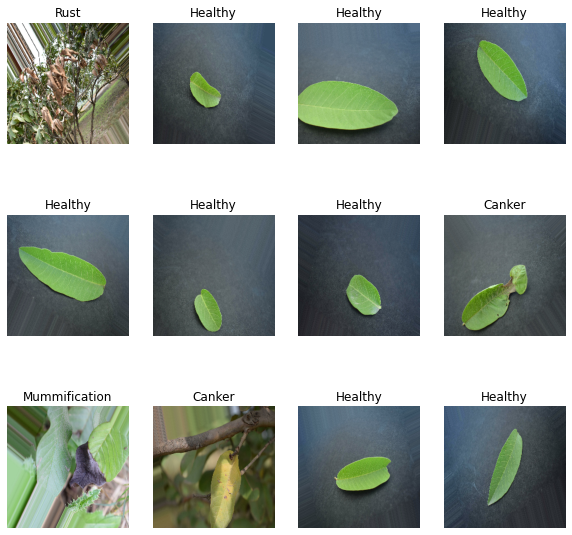

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

## Augmented image view

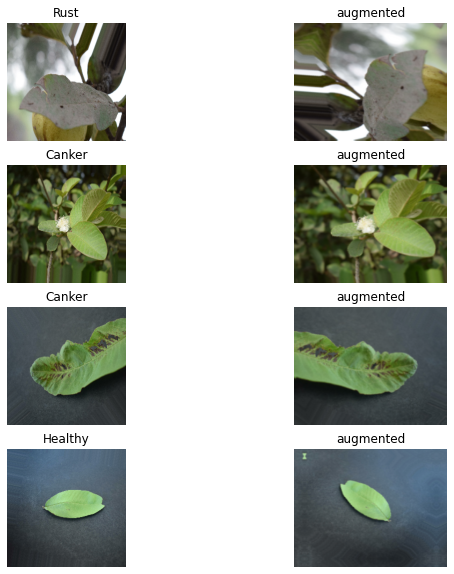

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

## Create CheckPoint

In [ ]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

# Create model

In [ ]:
input_shape = (32, 224, 224, 3)
model = tf.keras.models.Sequential(
    [
        data_augmentation,
        tf.keras.layers.Conv2D(
          filters=64,
          kernel_size=3,
          activation='relu',
          input_shape=input_shape
        ),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(
          pool_size=2,
          padding='valid'
        ),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ]
)
model.build(input_shape=input_shape)


## Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

## Compile the model

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

## Fit the model

In [ ]:
history = model.fit(
    train_data,
    epochs=600,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

Epoch 1/600


2022-08-21 17:05:36.250623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


44/44 [==============================] - ETA: 0s - loss: 1.3489 - accuracy: 0.5519

2022-08-21 17:06:41.058813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 104 of 256
2022-08-21 17:06:51.025886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 209 of 256
2022-08-21 17:06:55.301793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


44/44 [==============================] - 102s 2s/step - loss: 1.3489 - accuracy: 0.5519 - val_loss: 1.2358 - val_accuracy: 0.5570
Epoch 2/600
44/44 [==============================] - 51s 1s/step - loss: 1.0762 - accuracy: 0.6042 - val_loss: 0.9664 - val_accuracy: 0.6323
Epoch 3/600
44/44 [==============================] - 50s 1s/step - loss: 0.9128 - accuracy: 0.6514 - val_loss: 0.9266 - val_accuracy: 0.6710
Epoch 4/600
44/44 [==============================] - 48s 1s/step - loss: 0.8432 - accuracy: 0.6587 - val_loss: 0.9202 - val_accuracy: 0.6667
Epoch 5/600
44/44 [==============================] - 50s 1s/step - loss: 0.7972 - accuracy: 0.6928 - val_loss: 0.7553 - val_accuracy: 0.7097
Epoch 6/600
44/44 [==============================] - 48s 1s/step - loss: 0.7464 - accuracy: 0.7291 - val_loss: 0.8260 - val_accuracy: 0.6710
Epoch 7/600
44/44 [==============================] - 48s 1s/step - loss: 0.7473 - accuracy: 0.7233 - val_loss: 0.7334 - val_accuracy: 0.7269
Epoch 8/600
44/44 [=====

## Plot the history

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


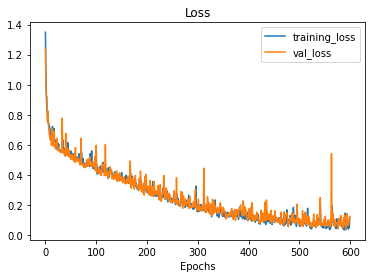

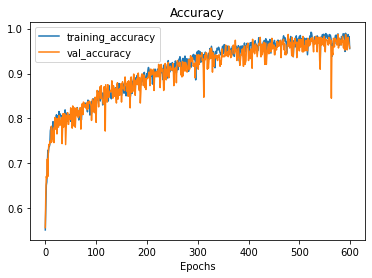

In [ ]:
plot_loss_curves(history)

## Check best weight validation data percentance

In [ ]:
def bestWeightModelEvaluate(model, weight_path, data):
  cp_model = tf.keras.models.clone_model(model)
  cp_model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )
  cp_model.load_weights(weight_path)
  cp_model.evaluate(data)

### Evaluate model

In [ ]:
# Train data
model.evaluate(train_data)
# Test data
model.evaluate(test_data)
# Valid data
model.evaluate(valid_data)

15/15 [==============================] - 0s 21ms/step - loss: 0.1205 - accuracy: 0.9570


2022-08-21 20:16:03.038610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 104 of 256
2022-08-21 20:16:13.003984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 209 of 256
2022-08-21 20:16:17.247336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


15/15 [==============================] - 46s 1s/step - loss: 0.1764 - accuracy: 0.9562


[0.1764443963766098, 0.9562363028526306]

### Best weight model evaluate

#### Test data

In [ ]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = test_data
)

15/15 [==============================] - 1s 21ms/step - loss: 0.0553 - accuracy: 0.9871


#### Validation data

In [ ]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = valid_data
)

15/15 [==============================] - 1s 22ms/step - loss: 0.0825 - accuracy: 0.9694


## Load best weight to the model

In [ ]:
model.load_weights(checkpoint_path)

## Prediction && visualize

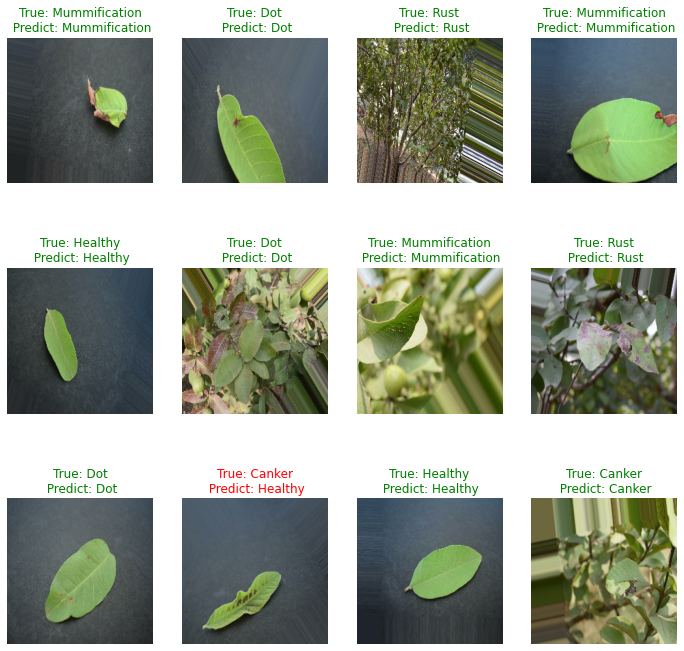

In [ ]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

## Download pretrain model

In [8]:
! wget "https://github.com/HSAkash/Guava-Disease/raw/main/pretrain_model.h5"

--2022-08-22 05:23:49--  https://github.com/HSAkash/Guava-Disease/raw/main/pretrain_model.h5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSAkash/Guava-Disease/main/pretrain_model.h5 [following]
--2022-08-22 05:23:50--  https://raw.githubusercontent.com/HSAkash/Guava-Disease/main/pretrain_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958984 (937K) [application/octet-stream]
Saving to: ‘pretrain_model.h5’

pretrain_model.h5   100%[===================>] 936.51K  --.-KB/s    in 0.05s   

2022-08-22 05:23:50 (18.9 MB/s) - ‘pretrain_model.h5’ saved [958984/958984]



### Load model

In [9]:
load_model = tf.keras.models.load_model("pretrain_model.h5")

### Summary load model

In [ ]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

### Summary main model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

## Evaluate load model with valid data and test_data

### Test data

In [ ]:
load_model.evaluate(test_data)

15/15 [==============================] - 0s 21ms/step - loss: 0.0543 - accuracy: 0.9849


[0.05426013842225075, 0.9849462509155273]

### Validation data

In [ ]:
load_model.evaluate(valid_data)

15/15 [==============================] - 0s 22ms/step - loss: 0.0807 - accuracy: 0.9803


[0.0806896984577179, 0.9803063273429871]

## Prediction && visualize

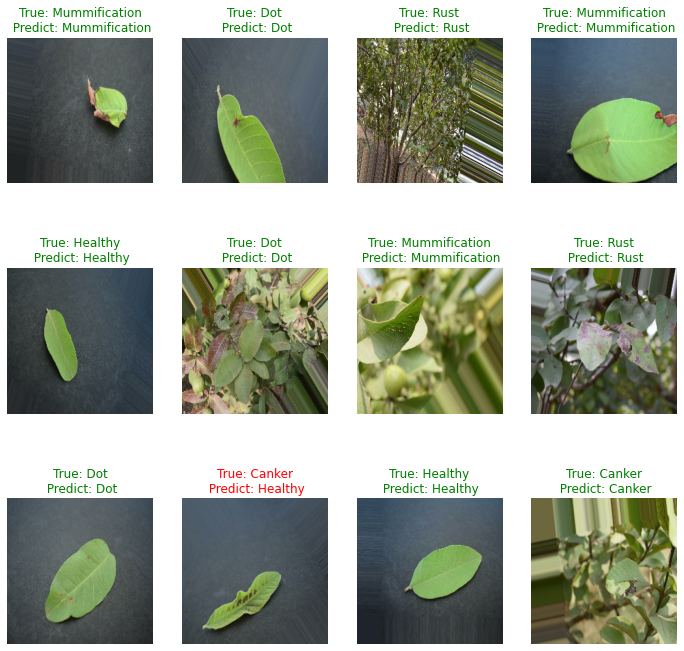

In [ ]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

## Confusion matrix

In [37]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [46]:
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = load_model.predict(test_data)

In [47]:
y_true = np.argmax(y_true, axis=-1)
y_pred = np.argmax(y_pred, axis=-1)

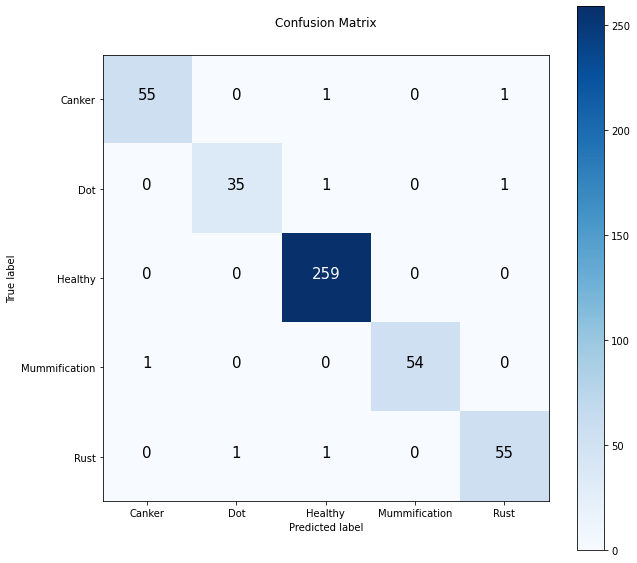

In [48]:
make_confusion_matrix(y, y_pred, class_names)